# Stage 3 - Blocking
## Step 0: Import Required Packages
Below is a list of the python packages we used while preforming Stage 3 of the project.

In [1]:
import json
import pandas as pd
import re
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from urllib2 import urlopen
%matplotlib inline

## Step 1: Load & Prepare Data
In this step we will __load__ our data into the python notebook and __manipulate__ the data so that it is in a format that is appropriate in order to analyze each attribute.

In [2]:
# Links to .CSV tables on Github
table_spoj = "https://raw.githubusercontent.com/KaranTalreja/CS638\
/master/spoj/json/problems.csv?token=AD_cZSMc8KZkEiPmKmMkn2UTb6Oqs1\
Etks5YJip_wA%3D%3D"

# Load table to Pandas dataframe
table_A = pd.read_csv(urlopen(table_spoj))

In [3]:
table_A.head(2)

,time_limit,user_ranks,description,title,url,implementation_difficulty,concept_difficulty,languages,source_limit,solved_by,output,date_added,tags,accuracy,memory_limit,id,added_by,input
0,10s,http://www.spoj.com/ranks/TEST,Your program is to use the brute-force appro...,"TEST - Life, the Universe, and Everything",http://www.spoj.com/problems/TEST,3.0,2.0,All,50000B,100118,NaN,2004-05-01,"88,4,89",32.93,1536MB,1,mima,NaN
1,5s,http://www.spoj.com/ranks/CMEXPR,The most important activity of ACM is the GS...,CMEXPR - Complicated Expressions,http://www.spoj.com/problems/CMEXPR,17.0,9.0,All except: NODEJS PERL 6 VB.net,50000B,655,Print asingle line for every expression. The...,2004-05-09,0,26.55,1536MB,10,adrian,There is asingle positive integer T on the f...


__Step 1.2:__ Manipulate Table Format & Select 10 Attributes

In [4]:
# "DateAdded" attribute as type datetime
def str_to_datetime(df):
    try:
        return datetime.strptime(df["date_added"], "%Y-%m-%d")
    except:
        pass

table_A["date_added"] = table_A.apply(str_to_datetime, axis=1)

__Step 1.3:__ Select 10 Attributes

In [5]:
table_A = table_A[["title", "description", "input",
                   "output","solved_by", "implementation_difficulty",
                   "concept_difficulty", "date_added"]]

table_A["difficulty"] = table_A["implementation_difficulty"] + \
table_A["concept_difficulty"]

## Bin difficulty based on percentile (beginner, easy, medium, 
## hard, challenge, N/A) Next stage...
table_A = table_A.drop(["implementation_difficulty", 
                        "concept_difficulty"], axis=1)
table_A.head(2)

,title,description,input,output,solved_by,date_added,difficulty
0,"TEST - Life, the Universe, and Everything",Your program is to use the brute-force appro...,NaN,NaN,100118,2004-05-01,5.0
1,CMEXPR - Complicated Expressions,The most important activity of ACM is the GS...,There is asingle positive integer T on the f...,Print asingle line for every expression. The...,655,2004-05-09,26.0


__Step 1.4:__ Process filed "title" to contain only Problem Code

In [6]:
def process_title(df):
    try:
        return df["title"].split(" - ")[0]
    except:
        pass

table_A["title"] = table_A.apply(process_title, axis=1)

In [7]:
table_A.head(2)

,title,description,input,output,solved_by,date_added,difficulty
0,TEST,Your program is to use the brute-force appro...,NaN,NaN,100118,2004-05-01,5.0
1,CMEXPR,The most important activity of ACM is the GS...,There is asingle positive integer T on the f...,Print asingle line for every expression. The...,655,2004-05-09,26.0


__Step 1.5:__ Process filed "date_added" to create new field "days_added".
This field contains the number of days since the problem has been added. This will be
further used to caculate the number of people who solve this problem per day. This would
be used as an indicator to the level of difficulty of this problem and would help in
blocking.

In [8]:
now = datetime.strptime("2016-11-01", "%Y-%m-%d")
def process_date_added(df):
    try:
        if False == pd.isnull(df["date_added"]):
            return np.timedelta64((now - df["date_added"]), 'D').astype(float)
        else:
            return -1
    except:
        pass
    
table_A["days_added"] = table_A.apply(process_date_added, axis=1)
table_A[table_A["days_added"] < 0]

,title,description,input,output,solved_by,date_added,difficulty,days_added
3182,AR2015PF,Please read the problem statement carefully....,NaN,NaN,4,NaT,51.0,-1.0


In [9]:
# Got manually from the website using above table
table_A["days_added"].iloc[3182] = np.timedelta64(now - datetime.strptime("2016-07-09", "%Y-%m-%d")\
                                                    , 'D').astype(float)
table_A.head(2)

/home/karan/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,title,description,input,output,solved_by,date_added,difficulty,days_added
0,TEST,Your program is to use the brute-force appro...,NaN,NaN,100118,2004-05-01,5.0,4567.0
1,CMEXPR,The most important activity of ACM is the GS...,There is asingle positive integer T on the f...,Print asingle line for every expression. The...,655,2004-05-09,26.0,4559.0


__Step 1.6:__ Process field "solved_by" and "days_added" to create new field "solve_rate"

In [10]:
def create_solve_rate(df):
    try:
        return df["solved_by"]/df["days_added"]
    except:
        pass
    
table_A["solve_rate"] = table_A.apply(create_solve_rate, axis=1)
table_A.head(2)

,title,description,input,output,solved_by,date_added,difficulty,days_added,solve_rate
0,TEST,Your program is to use the brute-force appro...,NaN,NaN,100118,2004-05-01,5.0,4567.0,21.922049
1,CMEXPR,The most important activity of ACM is the GS...,There is asingle positive integer T on the f...,Print asingle line for every expression. The...,655,2004-05-09,26.0,4559.0,0.143672


__Step 1.7:__ Drop "solved_by", "days_added" and "date_added" fields

In [11]:
table_A = table_A[["title", "description", "input",
                   "output", "difficulty", "solve_rate"]]
table_A.head(2)

,title,description,input,output,difficulty,solve_rate
0,TEST,Your program is to use the brute-force appro...,NaN,NaN,5.0,21.922049
1,CMEXPR,The most important activity of ACM is the GS...,There is asingle positive integer T on the f...,Print asingle line for every expression. The...,26.0,0.143672


__Step 1.8:__ Plot histograms and normalize the fields "difficulty" and "solve_rate"

In [14]:
# Helper function
def myround(x, base):
    return int(base * round(float(x)/base))

def numeric_histogram(table, attribute, range=[0,0], stdev=3, bins=20):
    values = table[attribute].astype(float)
    if range == [0,0]:
        range = [0, myround(values.std()*stdev, 5)]
    plt.hist(values, bins=bins, range=range)
    plt.title("%s - Histogram (%d bins)" % (attribute, bins))
    plt.show()
    summary_table = pd.DataFrame()
    summary_table["outliers"] = table[attribute][values[
            ((values - values.mean()) / values.std()).abs() > stdev
        ].index].astype(float)
    print "There are %d outliers outside of %d standard \
    deviations of %s." % (len(summary_table), stdev, attribute)
    return summary_table.sort_values(by="outliers")

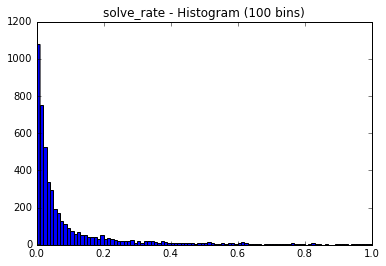

There are 24 outliers outside of 5 standard     deviations of solve_rate.


,outliers
567,3.016426
3487,3.027185
1463,3.031414
4456,3.207454
3729,3.533269
2337,3.633824
175,3.649396
1213,3.682965
74,3.955689
3727,4.501861


In [18]:
numeric_histogram(table_A, "solve_rate", range=[0,1], bins=100, stdev=5)

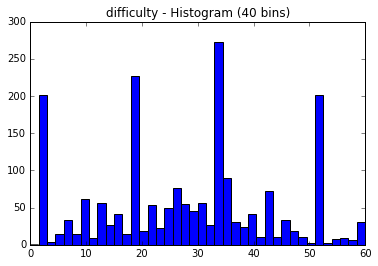

There are 30 outliers outside of 3 standard     deviations of difficulty.


,outliers
151,100.0
5032,100.0
4920,100.0
4686,100.0
4582,100.0
4508,100.0
4433,100.0
4170,100.0
4158,100.0
3716,100.0


In [20]:
numeric_histogram(table_A, "difficulty", bins=40)

__Step 1.8:__ Calculate Z-score columns for "solve_rate" and "difficulty" and put them into "solve_rate_normalized" and "difficulty_normalized"

In [22]:
cols = ["difficulty", "solve_rate"]
for col in cols:
    col_zscore = col + '_normalized'
    table_A[col_zscore] = (table_A[col] - table_A[col].mean())/table_A[col].std(ddof=0)
table_A.head(2)

,title,description,input,output,difficulty,solve_rate,difficulty_normalized,solve_rate_normalized
0,TEST,Your program is to use the brute-force appro...,NaN,NaN,5.0,21.922049,-1.329347,38.716293
1,CMEXPR,The most important activity of ACM is the GS...,There is asingle positive integer T on the f...,Print asingle line for every expression. The...,26.0,0.143672,-0.295130,-0.071428


In [23]:
table_A = table_A[["title", "description", "input", "output", "difficulty_normalized", "solve_rate_normalized"]]
table_A.head(2)

,title,description,input,output,difficulty_normalized,solve_rate_normalized
0,TEST,Your program is to use the brute-force appro...,NaN,NaN,-1.329347,38.716293
1,CMEXPR,The most important activity of ACM is the GS...,There is asingle positive integer T on the f...,Print asingle line for every expression. The...,-0.295130,-0.071428


__Saving CSV file for blocking stage__ : Finished preprocessing stage up till here. Now can proceed with blocking from the csv file "spoj_blocking.csv"

In [24]:
table_A.to_csv("spoj/json/spoj_blocking.csv")